In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt

In [719]:
# with open("resources/objects/private/nisse_15k.json") as f:
#     data = json.load(f)
with open("resources/objects/private/nisse_full.json") as f:
    data = json.load(f)

In [720]:
means = []
rots = []
scales = []
for k, v in data.items():
    means.append(v["xyz"])
    rots.append(np.array(v["rot"]))
    scales.append(v["scale"])

means = np.stack(means)
rots = np.stack(rots)
scales = np.clip(np.stack(scales), a_min=1e-2, a_max=1e14)

In [721]:
means.shape

(157291, 3)

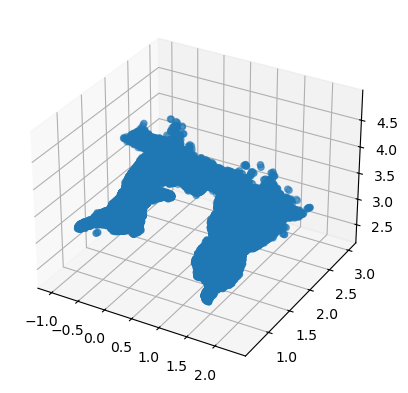

In [722]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*means.T)

In [723]:
aabb = [means.min(0), means.max(0)]
boxsize = aabb[1] - aabb[0]
aabb_root = [aabb[0] - boxsize * 0.1, aabb[1] + boxsize * 0.1]
aabb_root, aabb

In [726]:
cond0 = ((aabb[0] < means) & (aabb[1] > means)) # In the box
dist = np.stack((np.abs(means - aabb[0]), np.abs(means - aabb[1]))).min(0)
dist[cond0] = 0
dist.shape

In [729]:
dist[0] = np.array((1, 2, 3))
r, d = rots[0:1], dist[0:1]
np.matmul(rots, dist[..., None]).squeeze(-1).shape

(157291, 3)

In [730]:
r @ d.T, np.matmul(rots, dist[..., None]).squeeze(-1)[0]

(array([[[2.57608231],
         [0.10510292],
         [2.41188857]]]),
 array([2.57608231, 0.10510292, 2.41188857]))

In [731]:
# constraint = scales.min(1) > 1e-3
constraint = means[:, 0] < 0.6
constraint.shape, constraint.sum()

(157291,)

In [734]:
def gaussian_in_aabb(aabb):
    cond0 = ((aabb[0] < means) & (aabb[1] > means)) # In the box
    dist = np.stack((np.abs(means - aabb[0]), np.abs(means - aabb[1]))).min(0)
    dist[cond0] = 0
    dist = np.matmul(rots, dist[..., None]).squeeze(-1) / scales
    dist = np.sqrt((dist ** 2).sum(1))
    # cond1 = dist <= (scales.max(1) * 3)
    cond1 = dist <= 3
    # return (cond0.all(1) | cond1) & constraint
    return cond0.all(1) & constraint

def in_aabb(aabb):
    # cond = (aabb[0] < means) & (aabb[1] > means)
    cond = gaussian_in_aabb(aabb)
    return cond

def get_count(aabb):
    cond = gaussian_in_aabb(aabb)
    return cond.sum()

def split_aabb(aabb, axis=None, at=0.5):
    split = aabb[0] + (aabb[1] - aabb[0]) * at
    # print(split)
    if axis is None:
        return [aabb[0], split], [split, aabb[1]]
    aabb0 = [np.copy(aabb[0]), np.copy(aabb[1])]
    aabb1 = [np.copy(aabb[0]), np.copy(aabb[1])]
    aabb0[1][axis] = split[axis]
    aabb1[0][axis] = split[axis]
    return aabb0, aabb1

def get_split_costs(aabb, splits=[0.5]):
    costs = [[], [], []]
    for split in splits:
        for axis in range(3):
            aabb0, aabb1 = split_aabb(aabb, axis, split)
            costa = get_count(aabb0)
            costb = get_count(aabb1)
            costs[axis].append(abs(costa - costb) / (costa + costb))
    return np.array(costs)

        

In [735]:
splits = np.linspace(0.1, .9, 9)
# splits = [0.5]
costs = get_split_costs(aabb, splits=splits)
axis_split = np.argmin(costs.min(1))
split = splits[np.argmin(costs[axis_split])]
costs, axis_split, costs.min(1), splits, split

(array([[0.99825152, 0.57549265, 0.424579  , 0.8673737 , 1.        ,
         1.        , 1.        , 1.        , 1.        ],
        [0.9618488 , 0.79554282, 0.40113221, 0.08245073, 0.27277678,
         0.65067718, 0.89615192, 0.9818273 , 0.99988535],
        [1.        , 0.9987388 , 0.93931924, 0.33377284, 0.39654604,
         0.83575779, 0.98056611, 0.99469724, 0.99891078]]),
 1,
 array([0.424579  , 0.08245073, 0.33377284]),
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 0.4)

In [736]:
aabb0, aabb1 = split_aabb(aabb, axis_split, split)

In [737]:
get_count(aabb0), get_count(aabb1)

(32011, 37764)

In [738]:
a, b = in_aabb(aabb0), in_aabb(aabb1)

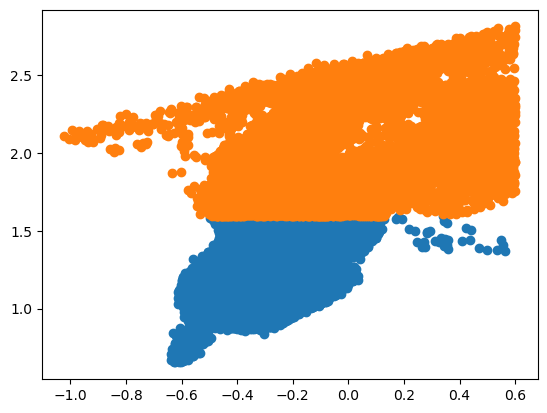

In [739]:
plt.scatter(means[a, 0], means[a, 1])
plt.scatter(means[b, 0], means[b, 1])

In [714]:
from collections import OrderedDict

In [741]:
structure = dict()

# def stop(aabb):
#     c = get_count(aabb)
#     # print(c)
#     return c < 1000

def stop(aabb, aabb0, aabb1):
    count, count0, count1 = get_count(aabb), get_count(aabb0), get_count(aabb1)
    return (max(count0, count1) >= (count - count / 4)) or count < 10000
    
    
splits = np.linspace(0.1, .9, 9)
def get_structure(aabb, idx, depth):
    # print(idx)
    data = {
        "mins": aabb[0].tolist() + [False],
        "maxs": aabb[1].tolist(),
    }
    if get_count(aabb) == 0:
        return idx - 1
    # if stop(aabb):
    #     if get_count(aabb) == 0:
    #         return idx - 1
    #     children = np.where(in_aabb(aabb))[0]
    #     data["mins"][-1] = True
    #     data["child_indices"] = children.tolist()
    #     structure[idx] = data
    #     return idx
    
    # costs = get_split_costs(aabb)
    # axis_split = np.argmin(costs)
    # aabb0, aabb1 = split_aabb(aabb, axis_split)

    costs = get_split_costs(aabb, splits=splits)
    axis_split = np.argmin(costs.min(1))
    split = splits[np.argmin(costs[axis_split])]
    aabb0, aabb1 = split_aabb(aabb, axis_split, split)

    if stop(aabb, aabb0, aabb1):
        children = np.where(in_aabb(aabb))[0]
        print(children.size)
        print(depth)
        data["mins"][-1] = True
        data["child_indices"] = children.tolist()
        structure[idx] = data
        return idx
    
    idxa = idx + 1
    idx0 = get_structure(aabb0, idxa, depth+1)
    idxb = idx0 + 1
    idx1 = get_structure(aabb1, idxb, depth+1)
    # print(idxa, idx0)

    children = []
    if idxa <= idx0:
        children.append(idxa)
    if idxb <= idx1:
        children.append(idxb)
    data["child_indices"] = children
    # if len(children) == 1:
    #     print("then here", idx)
    #     child = children[0]
    #     print(child)
    #     data["child_indices"] = structure[child]["child_indices"]
    #     data["mins"][-1] = structure[child]["mins"][-1]
    #     del structure[child]
    
    structure[idx] = data
    return idx1

get_structure(aabb, 0, 0)
# structure[0]["mins"] = aabb_root[0].tolist() + [False]
# structure[0]["maxs"] = aabb_root[1].tolist()
structure = OrderedDict(sorted(structure.items()))
len(structure)

7611
3
9530
3
6273
3
8597
3
5595
4
5365
4
5199
4
5240
4
9340
3
7025
3


19

In [742]:
points = set()
for k, v in structure.items():
    if v["mins"][-1]:
        points |= set(v["child_indices"])
len(points)

69775

In [743]:
# with open("resources/objects/private/nisse_15k_spatial_bvh_v1.json", "w") as f:
#     json.dump(structure, f, indent=6)
with open("resources/objects/private/nisse_full_spatial_bvh.json", "w") as f:
    json.dump(structure, f, indent=6)